In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
import pandas as pd
full_data = pd.read_csv("../input/gimana/GIM_Dataset.csv")
#full_data
y = full_data['Target']
sns.set_style('darkgrid')

Splitting Dataset into Training and Test set:

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_data, y, test_size = 0.2, random_state = 42)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

Check for Missing Value Columns :

In [3]:
na_columns = X_train.isna().sum()
print(na_columns[na_columns!=0])

Series([], dtype: int64)


Checking Distribution of dependent Variable

**Outlier Analysis and EDA**

(862, 27)

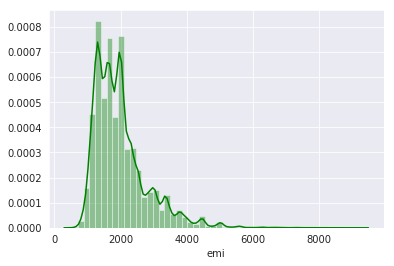

In [4]:
sns.distplot(X_train['emi'],color='g')
s = 'emi'
l = X_train[s].mean()-3*X_train[s].std()
u = X_train[s].mean()+ 3*X_train[s].std()
ind = X_train[X_train[s]>u].index
X_train[X_train[s]>u].shape

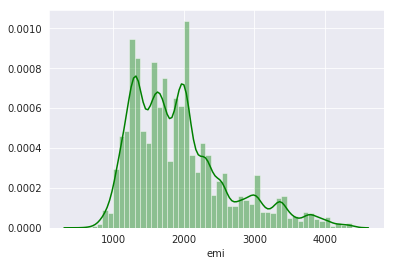

In [5]:
X_train= X_train.drop(ind)
sns.distplot(X_train['emi'],color='g')

**Feature Engineering**

In [6]:
X_train['emi_to_mean_pinCode'] = X_train['emi'] / X_train.groupby(['pinCode'])['emi'].transform('mean')
X_test['emi_to_mean_pinCode'] = X_test['emi'] / X_test.groupby(['pinCode'])['emi'].transform('mean')

**Feature Selection**

In [7]:
numericCols = ['timesFlowedTotalbyMOB','timesFlowed3M','timesBounced3M','averageDelayEMI','timesFlowedTotal','numberEnquired9M','numberEnquired1M','emi','maxContMobFlowed', 'tenureinMonths','allocatedToColAgent', 'allocatedToFC','numberLiveUnSecAcc']
categoricalCols = ['Target','flowedInLastMonth','pinCode','dealerCode','bounceReason','aadharAvailable','modelCode','schemeType','surrogate','qualification','productCode','panVoteIdAvailable','residentType']

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]), <a list of 13 Text xticklabel objects>)

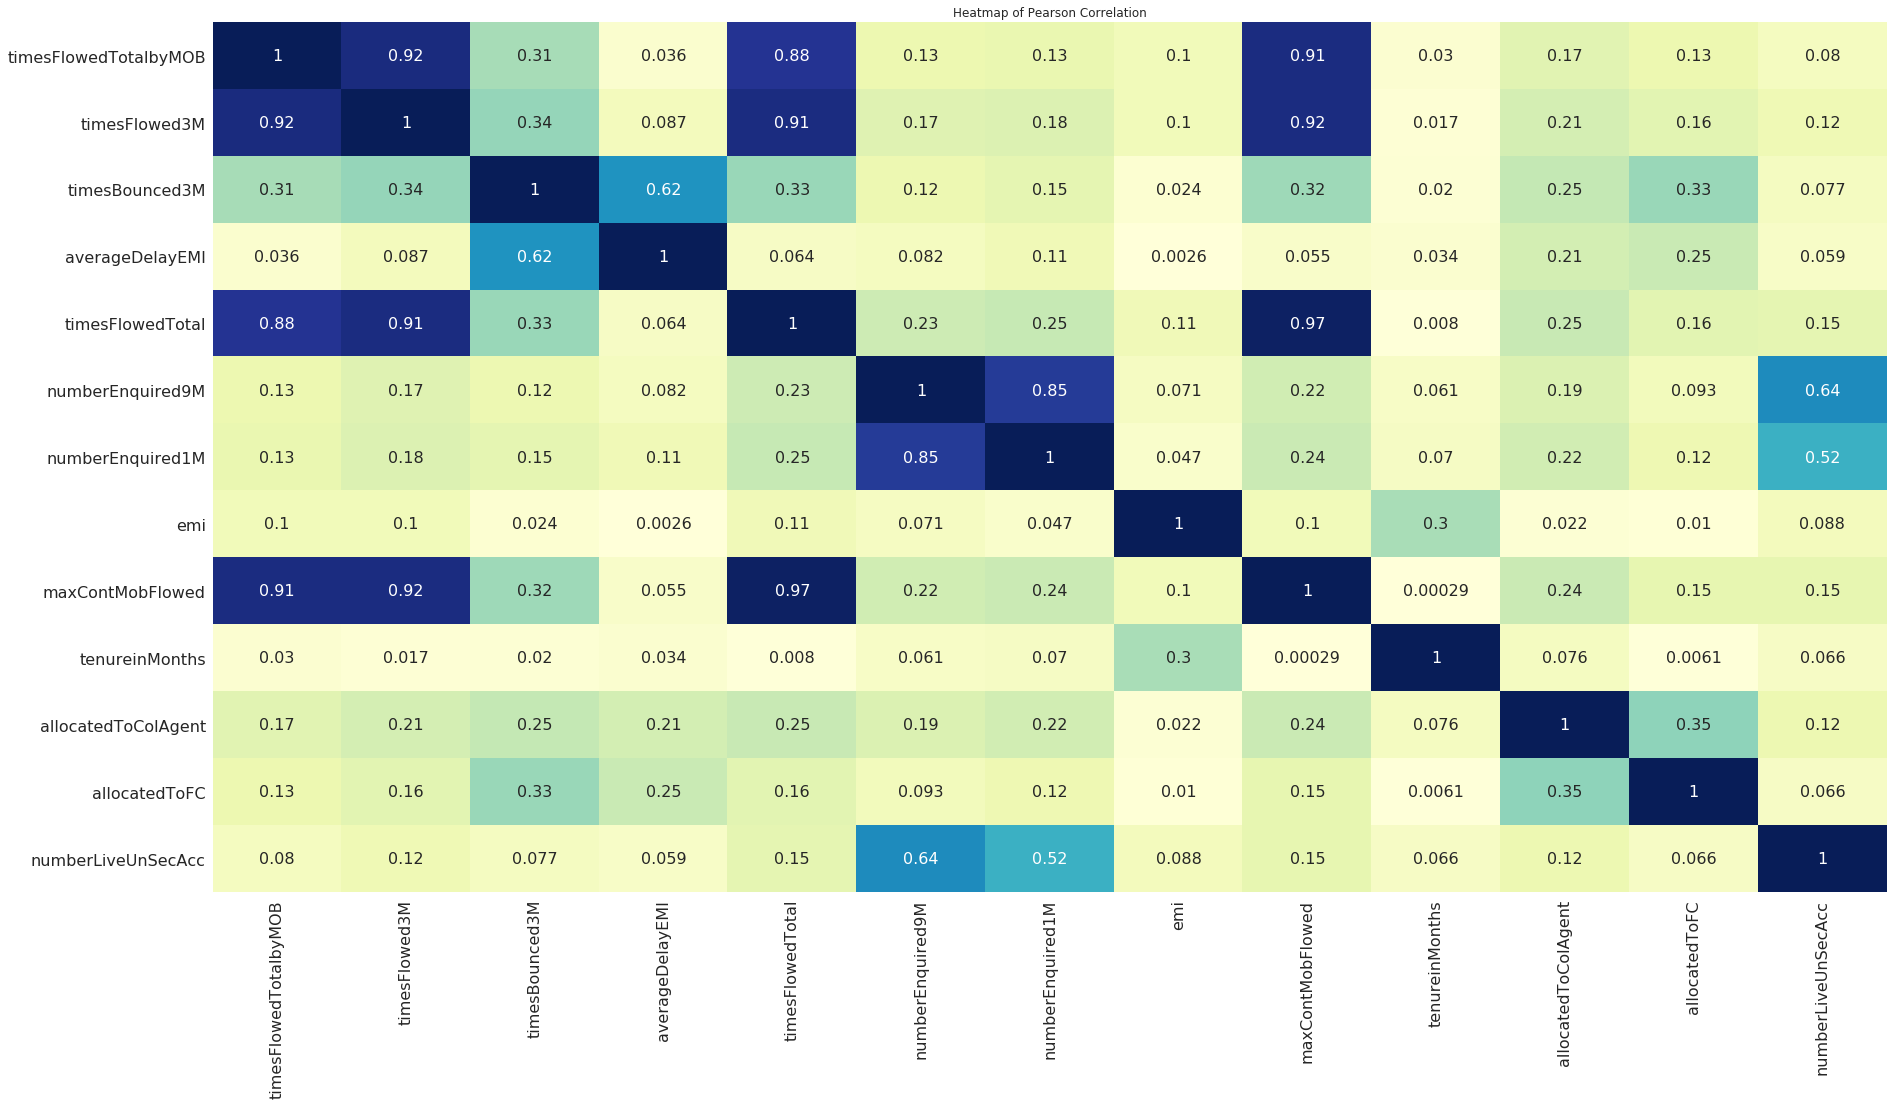

In [8]:
X_train_num = X_train[numericCols]
correlationMatrix = X_train_num.corr().abs()
plt.figure(figsize=(30,16))
heat = sns.heatmap(data=correlationMatrix, annot=True,annot_kws={'size':16},cbar=False,cmap='YlGnBu')
plt.title('Heatmap of Pearson Correlation')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16,rotation='vertical')

We eliminate one column out those pairs which show high correlation(greater than 0.7).

In [9]:
upper = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop
for i_var in to_drop:
    numericCols.remove(i_var)
numericCols

['timesFlowedTotalbyMOB',
 'timesBounced3M',
 'averageDelayEMI',
 'numberEnquired9M',
 'emi',
 'tenureinMonths',
 'allocatedToColAgent',
 'allocatedToFC',
 'numberLiveUnSecAcc']

In [10]:
to_drop

['timesFlowed3M', 'timesFlowedTotal', 'numberEnquired1M', 'maxContMobFlowed']

**Categorical Feature Selection**

In [11]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [12]:
cT = ChiSquare(X_train)
#Feature Selection
for var in categoricalCols:
    cT.TestIndependence(colX=var,colY="Target" ) 

Target is IMPORTANT for Prediction
flowedInLastMonth is IMPORTANT for Prediction
pinCode is IMPORTANT for Prediction
dealerCode is IMPORTANT for Prediction
bounceReason is IMPORTANT for Prediction
aadharAvailable is NOT an important predictor. (Discard aadharAvailable from model)
modelCode is IMPORTANT for Prediction
schemeType is IMPORTANT for Prediction
surrogate is IMPORTANT for Prediction
qualification is IMPORTANT for Prediction
productCode is IMPORTANT for Prediction
panVoteIdAvailable is IMPORTANT for Prediction
residentType is IMPORTANT for Prediction


In [13]:
categoricalCols.remove('aadharAvailable')

In [14]:
features = numericCols + categoricalCols
X_train = X_train.loc[:,features]

Label encoding Categorical Features - train set

In [15]:
enc = ['pinCode','dealerCode','bounceReason','panVoteIdAvailable','modelCode','schemeType','surrogate','qualification','productCode','residentType']
from sklearn.preprocessing import LabelEncoder
for c in enc:
    lb = LabelEncoder()
    X_train[c] = lb.fit_transform(X_train[c])

In [16]:
X_train

,timesFlowedTotalbyMOB,timesBounced3M,averageDelayEMI,numberEnquired9M,emi,tenureinMonths,allocatedToColAgent,allocatedToFC,numberLiveUnSecAcc,Target,flowedInLastMonth,pinCode,dealerCode,bounceReason,modelCode,schemeType,surrogate,qualification,productCode,panVoteIdAvailable,residentType
48572,0.000000,0,0.0,0,1600,10,0.000000,0.000000,0,0,0,91,4513,1,2735,1,5,0,7,0,0
38696,75.000000,3,18.0,0,1900,10,0.500000,0.000000,0,1,1,2086,3660,0,2119,2,5,0,7,0,1
13611,25.000000,2,0.0,0,1999,10,0.000000,0.500000,0,0,0,479,4066,0,2733,2,7,1,7,0,0
35213,33.333333,3,40.0,0,2917,12,0.000000,0.333333,0,0,0,278,5251,1,2305,1,7,0,10,0,0
31766,0.000000,3,18.5,0,2049,10,0.666667,0.000000,0,0,0,90,6528,0,2732,2,5,1,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,0.000000,3,20.0,0,4250,9,0.000000,0.500000,0,0,0,3010,1867,0,1404,1,7,1,10,0,0
38158,0.000000,3,16.0,2,1042,12,0.000000,0.833333,1,0,0,3098,288,1,187,1,7,1,11,0,0
860,16.666667,2,13.0,1,1649,10,0.000000,0.500000,0,1,1,1685,5411,0,1610,2,5,6,7,1,0
15795,33.333333,3,22.0,2,1949,10,0.166667,0.666667,2,0,0,3980,1079,0,2121,2,7,2,7,0,0


in the same way, we preprocess the Test set data

Test Set before preprocessing

In [17]:
X_test

,id,flowedInLastMonth,timesFlowedTotal,timesFlowed3M,numberEnquired9M,pinCode,dealerCode,timesBounced3M,bounceReason,averageDelayEMI,numberLiveUnSecAcc,numberEnquired1M,aadharAvailable,modelCode,schemeType,emi,surrogate,qualification,productCode,timesFlowedTotalbyMOB,maxContMobFlowed,tenureinMonths,panVoteIdAvailable,residentType,allocatedToColAgent,allocatedToFC,Target,emi_to_mean_pinCode
12628,AGMT12628,0,0,0,0,422103,CD09743,1,NonTechnical,0.00,0,0,N,CD0005599,CDNOR,2334,NONE,GRADUATE,TV,0.0,0,12,N,OWNED,0.000000,0.000000,1,1.316908
37730,AGMT37730,0,0,0,0,521185,CD05716,0,NonTechnical,0.00,0,0,N,CD00128573,CDOEM,1450,Own house proof,UNDER GRADUATE,FRIDGE,0.0,0,10,N,OWNED,0.000000,0.000000,0,0.828571
39991,AGMT39991,0,0,0,2,560051,CD09233,3,Technical,6.25,0,2,N,CD00124123,CDSPL,1199,Debit/Credit Card,SSC,MOBILE,0.0,0,10,Y,OWNED,0.000000,0.000000,0,0.677529
8525,AGMT8525,0,0,0,0,509338,CD09593,0,NonTechnical,0.00,0,0,N,CD00129259,CDOEM,1500,Debit/Credit Card,12TH,MOBILE,0.0,0,10,N,OWNED,0.000000,0.000000,0,0.802998
8279,AGMT8279,0,0,0,0,607803,CD06482,1,Technical,0.00,0,0,N,CD00129259,CDOEM,1067,Debit/Credit Card,GRADUATE,MOBILE,0.0,0,15,N,RENT,0.000000,0.000000,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49914,AGMT49914,0,0,0,9,711104,CD03748,3,NonTechnical,23.00,3,9,N,CD00126605,CDOEM,1567,Debit/Credit Card,UNDER GRADUATE,MOBILE,0.0,0,15,N,OWNED,0.666667,0.000000,0,0.856869
34428,AGMT34428,1,3,2,0,628656,CD03842,3,NonTechnical,10.00,0,0,N,CD00129256,CDOEM,2050,NONE,12TH,MOBILE,50.0,2,10,N,OWNED,0.000000,0.750000,1,1.336957
45810,AGMT45810,0,0,0,0,573201,CD01466,3,Technical,10.50,0,0,N,CD00129257,CDOEM,2100,Debit/Credit Card,UNDER GRADUATE,MOBILE,0.0,0,10,N,OWNED,0.000000,0.000000,0,1.118602
30357,AGMT30357,0,0,0,0,521230,CD15809,3,NonTechnical,20.50,0,0,N,CD00130093,CDOEM,4000,NONE,UNDER GRADUATE,AC,0.0,0,10,N,RENT,0.000000,0.333333,0,1.901321


Preprocessing for Test Set

Label encoding Categorical Features - test set

In [18]:
features = numericCols + categoricalCols
X_test = X_test.loc[:,features]

enc = ['pinCode','dealerCode','bounceReason','panVoteIdAvailable','modelCode','schemeType','surrogate','qualification','productCode','residentType']
from sklearn.preprocessing import LabelEncoder
for c in enc:
    lb = LabelEncoder()
    X_test[c] = lb.fit_transform(X_test[c])


In [19]:
X_test

,timesFlowedTotalbyMOB,timesBounced3M,averageDelayEMI,numberEnquired9M,emi,tenureinMonths,allocatedToColAgent,allocatedToFC,numberLiveUnSecAcc,Target,flowedInLastMonth,pinCode,dealerCode,bounceReason,modelCode,schemeType,surrogate,qualification,productCode,panVoteIdAvailable,residentType
12628,0.0,1,0.00,0,2334,12,0.000000,0.000000,0,1,0,352,2897,0,298,0,7,1,9,0,0
37730,0.0,0,0.00,0,1450,10,0.000000,0.000000,0,0,0,976,1711,0,1506,1,8,6,4,0,0
39991,0.0,3,6.25,2,1199,10,0.000000,0.000000,0,0,0,1279,2772,1,863,2,5,5,7,1,0
8525,0.0,0,0.00,0,1500,10,0.000000,0.000000,0,0,0,831,2857,0,1558,1,5,0,7,0,0
8279,0.0,1,0.00,0,1067,15,0.000000,0.000000,0,0,0,2116,1914,1,1558,1,5,1,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49914,0.0,3,23.00,9,1567,15,0.666667,0.000000,3,0,0,2827,1105,0,1284,1,5,6,7,0,0
34428,50.0,3,10.00,0,2050,10,0.000000,0.750000,0,1,1,2328,1133,0,1555,1,7,0,7,0,0
45810,0.0,3,10.50,0,2100,10,0.000000,0.000000,0,0,0,1560,436,1,1556,1,5,6,7,0,0
30357,0.0,3,20.50,0,4000,10,0.000000,0.333333,0,0,0,987,4303,0,1633,1,7,6,0,0,1


separating dependent variable

In [20]:
y_train = X_train['Target']
X_train.drop(['Target'],1,inplace=True)

In [21]:
X_test.drop(['Target'],1,inplace=True)

Boring Stuff over, Now the FUN BEGINS..

In [22]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, class_weight='balanced')
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]

In [23]:
logreg_predictionsTest = classifier.predict_proba(X_train)[:,1]

In [24]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.7988928899703515
0.7891968046292468
0.8108499461206897


In [25]:
y1 = pd.DataFrame(predictions,columns=['prob'])
y1['hard'] = np.where(y1['prob']<0.5,0,1)
print(y1.groupby(['hard'])['prob'].count())
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y1['hard'])
print(cm)
logreg_real_auc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("CM Accuracy : "+str(logreg_real_auc))
logreg_pred = pd.DataFrame(predictions,columns=['Target'])
#a = cm[1,1]/(cm[1,1]+cm[1,0])#maximize
#print("Recall: ", a)

print("Cost Savings : ",155*cm[1,1]+0*cm[0,0]-180*cm[1,0]-25*cm[0,1])

hard
0    8902
1    3098
Name: prob, dtype: int64
[[8166 1050]
 [ 736 2048]]
CM Accuracy : 0.8511666666666666
Cost Savings :  158710


AUC : 0.8734345612702547


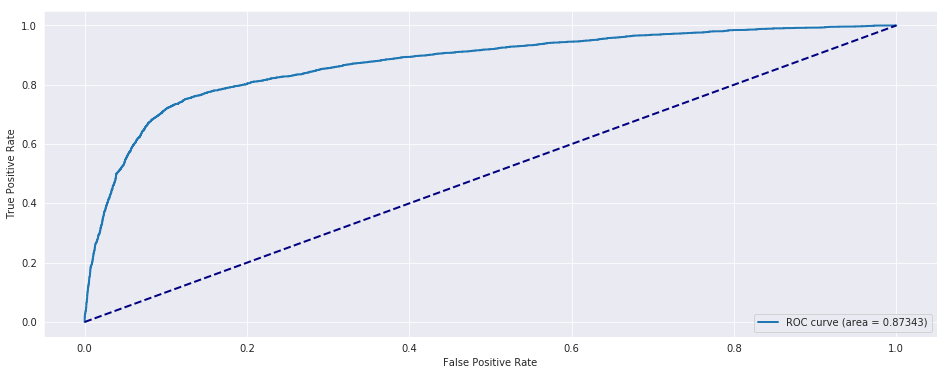

In [26]:
fprs_classifier, tprs_classifier, scores_classifier = [], [], []
from sklearn.metrics import roc_curve, auc
y_predict = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve( y_test, y_predict)
auc_score = auc(fpr, tpr)
logreg_auc_score = auc_score
scores_classifier.append(logreg_auc_score)
fprs_classifier.append(fpr)
tprs_classifier.append(tpr)
print("AUC : "+str(logreg_auc_score))
plt.figure(figsize=(16, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.5f)' % logreg_auc_score)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show() 

In [27]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 12, criterion = 'entropy', class_weight = 'balanced_subsample',random_state = 0)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]

In [28]:
rf_predictionsTest = classifier.predict_proba(X_train)[:,1]

In [29]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.7825390253088456
0.8057259495158912
0.7659280711206897


In [30]:
y1 = pd.DataFrame(predictions,columns=['prob'])
y1['hard'] = np.where(y1['prob']<0.5,0,1)
print(y1.groupby(['hard'])['prob'].count())
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y1['hard'])
print(cm)
rf_real_auc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("CM Accuracy : "+str(rf_real_auc))
rf_pred = pd.DataFrame(predictions,columns=['Target'])
#a = cm[1,1]/(cm[1,1]+cm[1,0])#maximize
#print("Recall: ", a)
print("Cost Savings : ",155*cm[1,1]+0*cm[0,0]-180*cm[1,0]-25*cm[0,1])

hard
0    9339
1    2661
Name: prob, dtype: int64
[[8399  817]
 [ 940 1844]]
CM Accuracy : 0.8535833333333334
Cost Savings :  96195


AUC : 0.8511737613994651


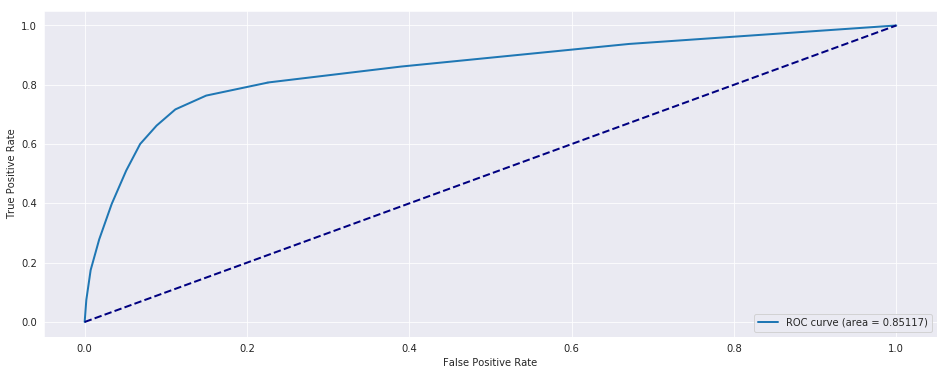

In [31]:
from sklearn.metrics import roc_curve, auc
y_predict = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve( y_test, y_predict)
auc_score = auc(fpr, tpr)
rf_auc_score = auc_score
scores_classifier.append(rf_auc_score)
fprs_classifier.append(fpr)
tprs_classifier.append(tpr)
print("AUC : "+str(rf_auc_score))
plt.figure(figsize=(16, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.5f)' % rf_auc_score)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show() 

In [32]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import confusion_matrix
    # Initialising the ANN
classifier = Sequential()
    # Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu', input_dim = 20))
    # Adding the second hidden layer
classifier.add(Dense(output_dim = 9, init= 'uniform', activation = 'relu'))
    # Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))
    # Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 2)
predictions = classifier.predict_proba(X_test)

Using TensorFlow backend.


Epoch 1/2
47138/47138 [==============================] - 6s 132us/step - loss: 0.4233 - accuracy: 0.8216
Epoch 2/2
47138/47138 [==============================] - 6s 131us/step - loss: 0.3806 - accuracy: 0.8497


In [33]:
ann_predictionsTest = classifier.predict_proba(X_train)

In [34]:
y1 = pd.DataFrame(predictions,columns=['prob'])
y1['hard'] = np.where(y1['prob']<0.5,0,1)
print(y1.groupby(['hard'])['prob'].count())
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y1['hard'])
print(cm)
ann_real_auc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("CM Accuracy : "+str(ann_real_auc))
ann_pred = pd.DataFrame(predictions,columns=['Target'])
a = cm[1,1]/(cm[1,1]+cm[1,0])#maximize
print("Recall: ", a)
b = cm[1,1]/(cm[1,1]+cm[0,1])
print("Precision: ", b)
print("F1: ", 2*a*b/(a+b))
print("Cost Savings : ",155*cm[1,1]+0*cm[0,0]-180*cm[1,0]-25*cm[0,1])

hard
0    9150
1    2850
Name: prob, dtype: int64
[[8277  939]
 [ 873 1911]]
CM Accuracy : 0.849
Recall:  0.6864224137931034
Precision:  0.6705263157894736
F1:  0.678381256656017
Cost Savings :  115590


AUC : 0.8445450939894635


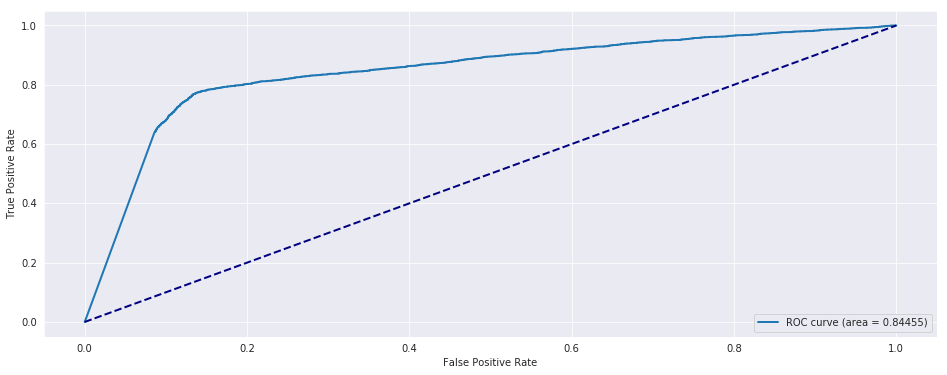

In [35]:
from sklearn.metrics import roc_curve, auc
y_predict = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve( y_test, y_predict)
auc_score = auc(fpr, tpr)
ann_auc_score = auc_score
scores_classifier.append(ann_auc_score)
fprs_classifier.append(fpr)
tprs_classifier.append(tpr)
print("AUC : "+str(ann_auc_score))
plt.figure(figsize=(16, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.5f)' % ann_auc_score)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show() 

In [36]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state = 0,scale_pos_weight=3)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]

In [37]:
xgb_predictionsTest = classifier.predict_proba(X_train)[:,1]

In [38]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.7961892042103379
0.7804913722155083
0.8201684476772031


In [39]:
y1 = pd.DataFrame(predictions,columns=['prob'])
y1['hard'] = np.where(y1['prob']<0.5,0,1)
print(y1.groupby(['hard'])['prob'].count())
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y1['hard'])
print(cm)
xgb_real_auc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("CM Accuracy : "+str(xgb_real_auc))
xgb_pred = pd.DataFrame(predictions,columns=['self_pay_status'])
#a = cm[1,1]/(cm[1,1]+cm[1,0])#maximize
#print("Recall: ", a)
print("Cost Savings : ",155*cm[1,1]+0*cm[0,0]-180*cm[1,0]-25*cm[0,1])

hard
0    8591
1    3409
Name: prob, dtype: int64
[[7967 1249]
 [ 624 2160]]
CM Accuracy : 0.8439166666666666
Cost Savings :  191255


AUC : 0.8816581131702486


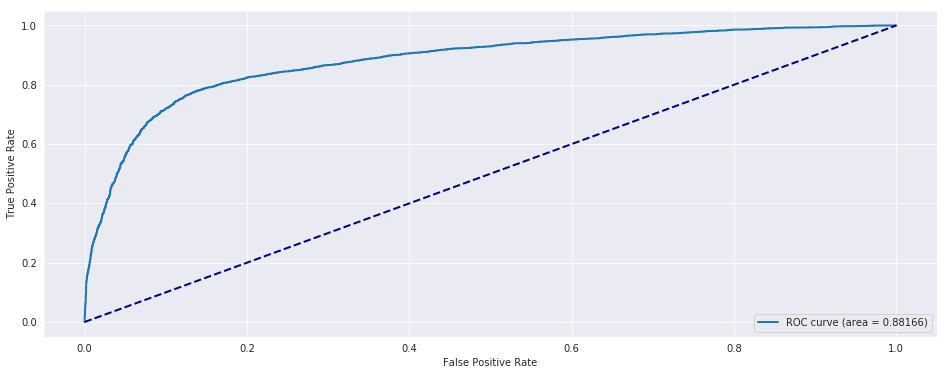

In [40]:
from sklearn.metrics import roc_curve, auc
y_predict = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve( y_test, y_predict)
auc_score = auc(fpr, tpr)
xgb_auc_score = auc_score
scores_classifier.append(xgb_auc_score)
fprs_classifier.append(fpr)
tprs_classifier.append(tpr)
print("AUC : "+str(xgb_auc_score))
plt.figure(figsize=(16, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.5f)' % xgb_auc_score)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show() 

In [41]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
classifier = LGBMClassifier(random_state = 0, scale_pos_weight=3)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]

In [42]:
lgb_predictionsTest = classifier.predict_proba(X_train)[:,1]

In [43]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.7964158634128106
0.7812450909018942
0.8190272539511494


In [44]:
y1 = pd.DataFrame(predictions,columns=['prob'])
y1['hard'] = np.where(y1['prob']<0.5,0,1)
print(y1.groupby(['hard'])['prob'].count())
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y1['hard'])
print(cm)
lgb_real_auc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("CM Accuracy : "+str(lgb_real_auc))
lgb_pred = pd.DataFrame(predictions,columns=['Target'])
#a = cm[1,1]/(cm[1,1]+cm[1,0])#maximize
#print("Recall: ", a)
print("Cost Savings : ",155*cm[1,1]+0*cm[0,0]-180*cm[1,0]-25*cm[0,1])

hard
0    8626
1    3374
Name: prob, dtype: int64
[[7989 1227]
 [ 637 2147]]
CM Accuracy : 0.8446666666666667
Cost Savings :  187450


AUC : 0.8806627841135857


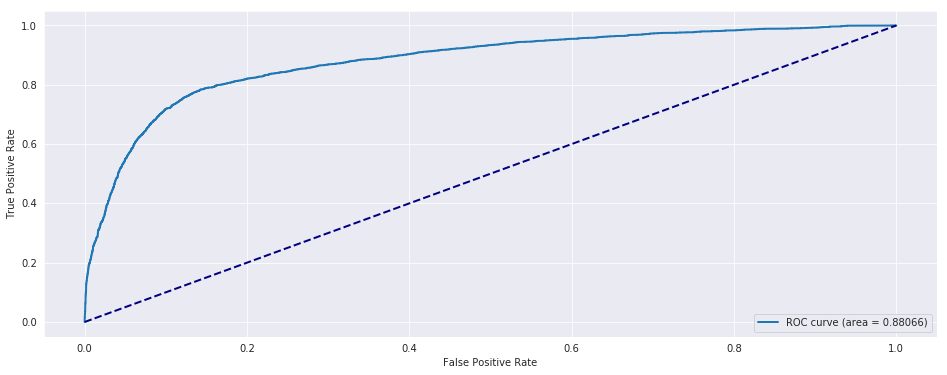

In [45]:
from sklearn.metrics import roc_curve, auc
y_predict = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve( y_test, y_predict)
auc_score = auc(fpr, tpr)
lgb_auc_score = auc_score
scores_classifier.append(lgb_auc_score)
fprs_classifier.append(fpr)
tprs_classifier.append(tpr)
print("AUC : "+str(lgb_auc_score))
plt.figure(figsize=(16, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.5f)' % lgb_auc_score)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show() 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text yticklabel objects>)

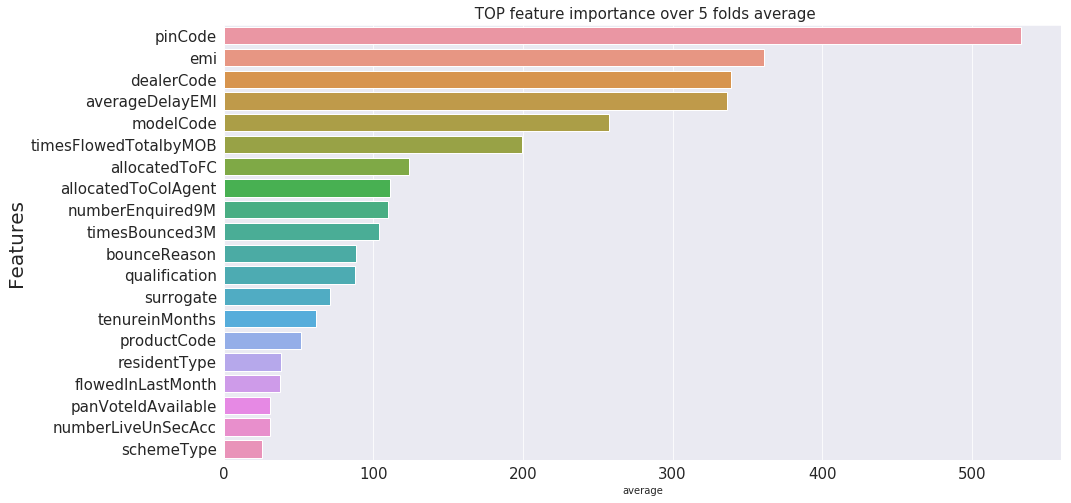

In [46]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_curve, auc
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    classifier = LGBMClassifier(random_state = 42)
    classifier.fit(X_train.iloc[train,:], y_train.iloc[train])
    feature_importances['fold_{}'.format(i + 1)] = classifier.feature_importances_
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(15, 8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title(' TOP feature importance over {} folds average'.format(cv.n_splits),fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Features',fontsize=20)
plt.yticks(fontsize=15)

In [47]:
#Stacking


In [48]:
rankings = classifier.feature_importances_.tolist()
features = list(X_train)
d = dict(zip(features,rankings))
d = pd.DataFrame(list(d.items()), columns=["features", "ranking"])
d.sort_values(["ranking"], ascending=False)

,features,ranking
10,pinCode,540
4,emi,354
2,averageDelayEMI,352
11,dealerCode,323
13,modelCode,264
0,timesFlowedTotalbyMOB,211
7,allocatedToFC,118
3,numberEnquired9M,117
6,allocatedToColAgent,104
1,timesBounced3M,97


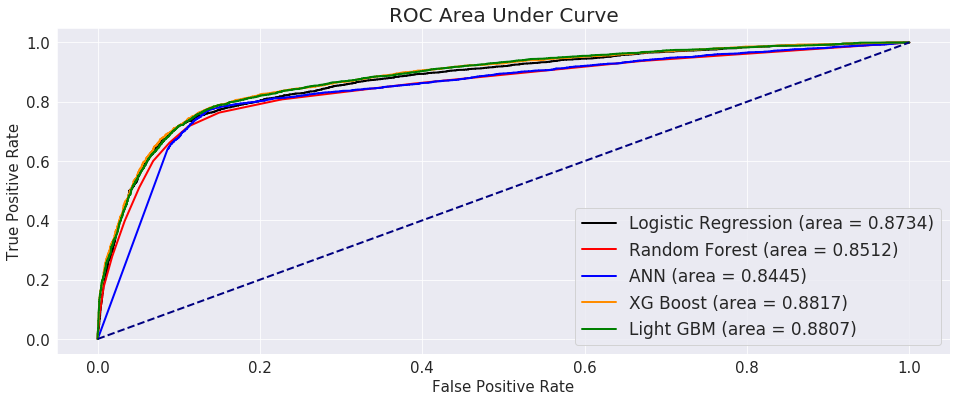

In [49]:
plt.figure(figsize=(16, 6))
lw = 2
model_list = ['Logistic Regression','Random Forest','ANN','XG Boost','Light GBM']
colors = ['black','red','blue','darkorange','green']
for i in range(0,5):
    plt.plot(fprs_classifier[i], tprs_classifier[i], color=colors[i],
             lw=lw, label="{} (area = {})".format(model_list[i],round(scores_classifier[i],4)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC Area Under Curve',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=15)
plt.legend(loc="lower right",fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()